No valid coloring found. Using best solution with energy 13.0
Coloring assignment:
Node 0: Color 2
Node 1: Color 2
Node 2: Color 2
Node 3: Color 3
Node 4: Color 3
Node 5: Color 1
Node 7: Color 3
Node 9: Color 2


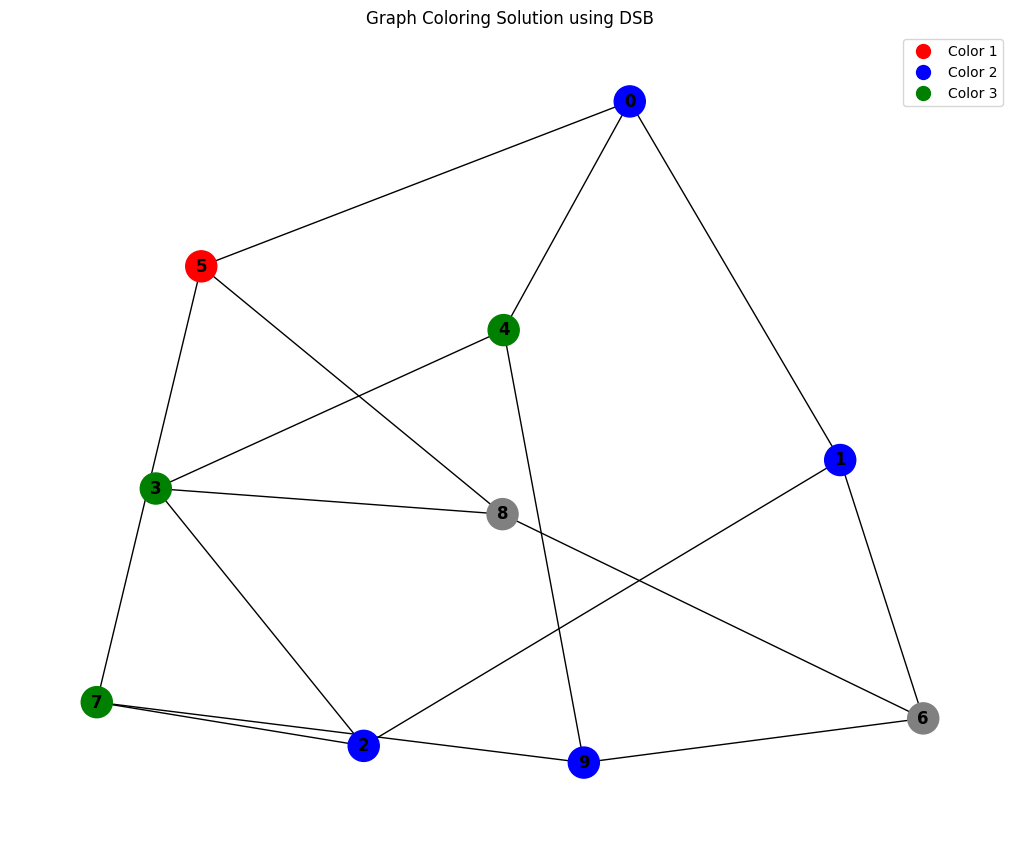

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Dict, Set

class DSBGraphColoring:
    """
    Implementation of Graph Coloring using Discrete Simulated Bifurcation (DSB)
    """
    
    def __init__(self, graph: nx.Graph, num_colors: int):
        """
        Initialize the DSB solver for graph coloring
        
        Args:
            graph: NetworkX graph object
            num_colors: Number of colors to use
        """
        self.graph = graph
        self.num_vertices = len(graph.nodes())
        self.num_colors = num_colors
        
        # Map internal indices to original node labels
        self.idx_to_node = {i: node for i, node in enumerate(graph.nodes())}
        self.node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
        
        # Initialize adjacency matrix
        self.adj_matrix = np.zeros((self.num_vertices, self.num_vertices))
        for i, j in graph.edges():
            i_idx, j_idx = self.node_to_idx[i], self.node_to_idx[j]
            self.adj_matrix[i_idx, j_idx] = 1
            self.adj_matrix[j_idx, i_idx] = 1  # Undirected graph
            
        # Initialize binary variables x[i][c] and momentum p[i][c]
        self.x = np.random.choice([-1, 1], size=(self.num_vertices, self.num_colors))
        self.p = np.zeros((self.num_vertices, self.num_colors))
        
    def calculate_forces(self) -> np.ndarray:
        """
        Calculate forces for each variable based on the Hamiltonian
        
        Returns:
            Array of forces for each variable
        """
        forces = np.zeros((self.num_vertices, self.num_colors))
        
        # Calculate forces from adjacent vertices constraint
        for i in range(self.num_vertices):
            for c in range(self.num_colors):
                # Force from adjacent vertices having the same color
                adjacent_force = 0
                for j in range(self.num_vertices):
                    if self.adj_matrix[i, j] == 1:
                        adjacent_force += self.adj_matrix[i, j] * self.x[j, c]
                
                # Force from one-color-per-vertex constraint
                sum_colors = np.sum(self.x[i, :])
                one_color_force = 2 * (sum_colors - 1) * self.x[i, c]
                
                # Total force (negative gradient of Hamiltonian)
                forces[i, c] = -adjacent_force - one_color_force
                
        return forces
    
    def update_variables(self, forces: np.ndarray, alpha: float, beta: float):
        """
        Update momentum and position variables using DSB dynamics
        
        Args:
            forces: Array of forces for each variable
            alpha: Driving amplitude
            beta: Dissipation rate
        """
        # Update momentum with driving and dissipation terms
        self.p = self.p + forces - beta * self.p + alpha * np.random.randn(*self.p.shape)
        
        # Update position based on momentum (discretized)
        self.x = np.sign(self.p)
    
    def is_valid_coloring(self) -> bool:
        """
        Check if the current state represents a valid coloring
        
        Returns:
            True if coloring is valid, False otherwise
        """
        # Convert x from {-1, 1} to {0, 1} for easier checking
        x_binary = (self.x + 1) / 2
        
        # Check if each vertex has exactly one color
        for i in range(self.num_vertices):
            if np.sum(x_binary[i, :]) != 1:
                return False
        
        # Check if adjacent vertices have different colors
        for i in range(self.num_vertices):
            for j in range(self.num_vertices):
                if self.adj_matrix[i, j] == 1:  # If vertices are adjacent
                    for c in range(self.num_colors):
                        if x_binary[i, c] == 1 and x_binary[j, c] == 1:
                            return False
        
        return True
    
    def extract_coloring(self) -> Dict:
        """
        Extract color assignment from binary variables
        
        Returns:
            Dictionary mapping node labels to colors (1-indexed)
        """
        colors = {}
        # Convert x from {-1, 1} to {0, 1}
        x_binary = (self.x + 1) / 2
        
        for i in range(self.num_vertices):
            for c in range(self.num_colors):
                if x_binary[i, c] == 1:
                    colors[self.idx_to_node[i]] = c + 1  # 1-indexed colors
        
        return colors
    
    def calculate_energy(self) -> float:
        """
        Calculate current energy (value of Hamiltonian)
        
        Returns:
            Current energy value
        """
        energy = 0
        x_binary = (self.x + 1) / 2
        
        # Energy from adjacent vertices with same color
        for i in range(self.num_vertices):
            for j in range(self.num_vertices):
                if self.adj_matrix[i, j] == 1:
                    for c in range(self.num_colors):
                        energy += self.adj_matrix[i, j] * x_binary[i, c] * x_binary[j, c]
        
        # Energy from one-color-per-vertex constraint
        for i in range(self.num_vertices):
            sum_colors = np.sum(x_binary[i, :])
            energy += (sum_colors - 1) ** 2
            
        return energy
    
    def solve(self, max_iter: int = 1000, alpha: float = 0.1, beta: float = 0.03) -> Dict:
        """
        Run DSB algorithm to find a valid coloring
        
        Args:
            max_iter: Maximum number of iterations
            alpha: Driving amplitude
            beta: Dissipation rate
            
        Returns:
            Dictionary mapping node labels to colors
        """
        best_energy = float('inf')
        best_x = np.copy(self.x)
        
        for iter in range(max_iter):
            # Calculate forces
            forces = self.calculate_forces()
            
            # Update variables
            self.update_variables(forces, alpha, beta)
            
            # Calculate current energy
            current_energy = self.calculate_energy()
            
            # Keep track of best solution
            if current_energy < best_energy:
                best_energy = current_energy
                best_x = np.copy(self.x)
                
            # Check if solution is valid
            if self.is_valid_coloring():
                print(f"Valid coloring found at iteration {iter+1}")
                return self.extract_coloring()
                
            # Gradually reduce alpha (annealing)
            alpha *= 0.9999
            
        # If no valid coloring found, return best solution found
        print(f"No valid coloring found. Using best solution with energy {best_energy}")
        self.x = best_x
        return self.extract_coloring()
    
    def visualize_solution(self, coloring: Dict = None):
        """
        Visualize the graph with the color assignment
        
        Args:
            coloring: Dictionary mapping node labels to colors
        """
        if coloring is None:
            coloring = self.extract_coloring()
            
        # Map colors to actual colors for visualization
        color_map = {
            1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'purple',
            6: 'orange', 7: 'pink', 8: 'brown', 9: 'cyan', 10: 'magenta'
        }
        
        # Create node color list for NetworkX
        node_colors = [color_map.get(coloring.get(node, 0), 'gray') for node in self.graph.nodes()]
        
        # Draw the graph
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(self.graph, seed=42)
        nx.draw(self.graph, pos, node_color=node_colors, with_labels=True, 
                node_size=500, font_weight='bold')
        
        # Add legend
        used_colors = set(coloring.values())
        patches = [plt.plot([], [], marker="o", ms=10, ls="", color=color_map[c], 
                           label=f"Color {c}")[0] for c in sorted(used_colors)]
        plt.legend(handles=patches, loc='best')
        
        plt.title("Graph Coloring Solution using DSB")
        plt.show()


# Example usage
def main():
    # Create a simple graph
    G = nx.petersen_graph()  # The Petersen graph needs at least 3 colors
    
    # Create DSB solver
    dsb = DSBGraphColoring(G, num_colors=3)
    
    # Solve graph coloring
    coloring = dsb.solve(max_iter=2000, alpha=0.15, beta=0.03)
    
    # Print coloring
    print("Coloring assignment:")
    for node, color in coloring.items():
        print(f"Node {node}: Color {color}")
    
    # Visualize solution
    dsb.visualize_solution(coloring)


if __name__ == "__main__":
    main()